# Inequality constraints

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(1793)
tf.random.set_seed(1793)

## The problem

In this tutorial, we replicate one of the results of <cite data-cite="gardner14"/>, specifically their synthetic experiment "simulation 1", which consists of an objective function with a single constraint, defined over a two-dimensional input domain. We'll start by defining the problem parameters.

In [2]:
import gpflow
import trieste

class Sim:
    threshold = 0.5

    @staticmethod
    def objective(input_data):
        x, y = input_data[..., -2], input_data[..., -1]
        z = tf.cos(2.0 * x) * tf.cos(y) + tf.sin(x)
        return z[:, None]

    @staticmethod
    def constraint(input_data):
        x, y = input_data[:, -2], input_data[:, -1]
        z = tf.cos(x) * tf.cos(y) - tf.sin(x) * tf.sin(y)
        return z[:, None]


search_space = trieste.space.Box([0, 0], [6, 6])

The objective and constraint functions are accessible as methods on the `Sim` class. Let's visualise these functions, as well as the constrained objective formed by applying a mask to the objective over regions where the constraint function crosses the threshold.

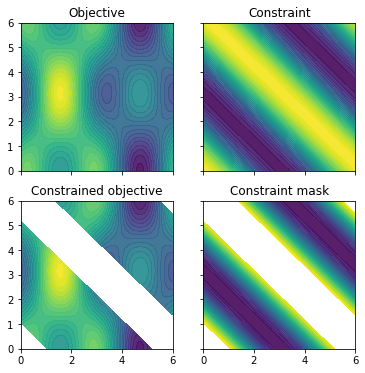

In [3]:
import matplotlib.pyplot as plt
from util.inequality_constraints_utils import plot_objective_and_constraints

plot_objective_and_constraints(search_space, Sim)
plt.show()

We'll make an observer that outputs the objective and constraint data, labelling each as shown.

In [4]:
OBJECTIVE = "OBJECTIVE"
CONSTRAINT = "CONSTRAINT"

def observer(query_points):
    return {
        OBJECTIVE: trieste.data.Dataset(query_points, Sim.objective(query_points)),
        CONSTRAINT: trieste.data.Dataset(query_points, Sim.constraint(query_points)),
    }

Let's randomly sample some initial data from the observer ...

In [5]:
num_initial_points = 5
initial_data = observer(search_space.sample(num_initial_points))

... and visualise those points on the constrained objective.

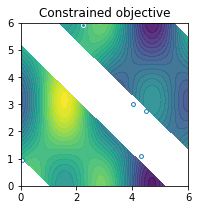

In [6]:
from util.inequality_constraints_utils import plot_init_query_points

plot_init_query_points(
    search_space,
    Sim,
    initial_data[OBJECTIVE].astuple(),
    initial_data[CONSTRAINT].astuple(),
)
plt.show()

## Modelling the two functions

We'll model the objective and constraint data with their own Gaussian process regression models.

In [7]:
def create_bo_model(data):
    variance = tf.math.reduce_variance(initial_data[OBJECTIVE].observations)
    lengthscale = 1.0 * np.ones(2, dtype=gpflow.default_float())
    kernel = gpflow.kernels.Matern52(variance=variance, lengthscales=lengthscale)
    gpr = gpflow.models.GPR(data.astuple(), kernel, noise_variance=1e-5)
    gpflow.set_trainable(gpr.likelihood, False)
    return trieste.models.create_model({
        "model": gpr,
        "optimizer": gpflow.optimizers.Scipy(),
        "optimizer_args": {
            "minimize_args": {"options": dict(maxiter=100)},
        },
    })


initial_models = {
    OBJECTIVE: create_bo_model(initial_data[OBJECTIVE]),
    CONSTRAINT: create_bo_model(initial_data[CONSTRAINT]),
}

## Define the acquisition process

We can construct the _expected constrained improvement_ acquisition function defined in <cite data-cite="gardner14"/>, where they use the probability of feasibility wrt the constraint model.

In [8]:
pof = trieste.acquisition.ProbabilityOfFeasibility(threshold=Sim.threshold)
eci = trieste.acquisition.ExpectedConstrainedImprovement(
    OBJECTIVE, pof.using(CONSTRAINT)
)
rule = trieste.acquisition.rule.EfficientGlobalOptimization(eci)

## Run the optimization loop

We can now run the optimization loop

In [9]:
num_steps = 20
bo = trieste.bayesian_optimizer.BayesianOptimizer(observer, search_space)

data = bo.optimize(
    num_steps, initial_data, initial_models, rule, track_state=False
).try_get_final_datasets()

Optimization completed without errors


To conclude this section, we visualise the resulting data. Orange dots show the new points queried during optimization. Notice the concentration of these points in regions near the local minima.

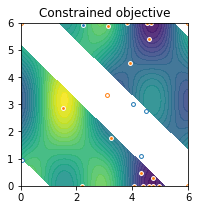

In [10]:
constraint_data = data[CONSTRAINT]
new_query_points = constraint_data.query_points[-num_steps:]
new_observations = constraint_data.observations[-num_steps:]
new_data = (new_query_points, new_observations)

plot_init_query_points(
    search_space,
    Sim,
    initial_data[OBJECTIVE].astuple(),
    initial_data[CONSTRAINT].astuple(),
    new_data,
)
plt.show()

## Batch-sequential strategy

It is sometimes beneficial to query several points at a time instead of one. We show here how to create an ad-hoc extensions of the previous acquistion function and use the `BatchAcquisitionRule`.

In [11]:
class BatchExpectedConstrainedImprovement(
    trieste.acquisition.BatchAcquisitionFunctionBuilder
):
    def __init__(self, sample_size, threshold):
        self._sample_size = sample_size
        self._threshold = threshold

    def prepare_acquisition_function(self, datasets, models):
        objective_model = models[OBJECTIVE]
        objective_dataset = datasets[OBJECTIVE]

        samplers = {
            tag: trieste.acquisition.BatchReparametrizationSampler(
                self._sample_size, model
            ) for tag, model in models.items()
        }

        pf = trieste.acquisition.probability_of_feasibility(
            models[CONSTRAINT], self._threshold, objective_dataset.query_points
        )
        is_feasible = pf >= 0.5

        mean, _ = objective_model.predict(objective_dataset.query_points)
        eta = tf.reduce_min(tf.boolean_mask(mean, is_feasible), axis=0)

        def batch_efi(at):
            samples = {
                tag: tf.squeeze(sampler.sample(at), -1)
                for tag, sampler in samplers.items()
            }
            feasible_mask = samples[CONSTRAINT] < self._threshold  # [N, S, B]
            improvement = tf.where(
                feasible_mask,
                tf.maximum(eta - samples[OBJECTIVE], 0.),
                0.
            )  # [N, S, B]
            batch_improvement = tf.reduce_max(improvement, axis=-1)  # [N, S]
            return tf.reduce_mean(
                batch_improvement, axis=-1, keepdims=True
            )  # [N, 1]

        return batch_efi


num_query_points = 4
batch_eci = BatchExpectedConstrainedImprovement(50, Sim.threshold)
batch_rule = trieste.acquisition.rule.BatchAcquisitionRule(
    num_query_points, batch_eci
)

We can now run the BO loop as before; note that here we also query twenty points, but in five batches of four points.

In [12]:
initial_models = {
    OBJECTIVE: create_bo_model(initial_data[OBJECTIVE]),
    CONSTRAINT: create_bo_model(initial_data[CONSTRAINT]),
}

num_steps = 5
batch_data = bo.optimize(
    num_steps, initial_data, initial_models, batch_rule, track_state=False
).try_get_final_datasets()

Optimization completed without errors


We visualise the resulting data as before.

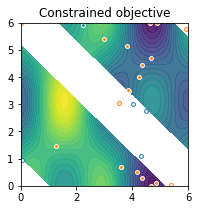

In [13]:
batch_constraint_data = batch_data[CONSTRAINT]
new_batch_data = (
    batch_constraint_data.query_points[-num_query_points * num_steps:],
    batch_constraint_data.observations[-num_query_points * num_steps:]
)

plot_init_query_points(
    search_space,
    Sim,
    initial_data[OBJECTIVE].astuple(),
    initial_data[CONSTRAINT].astuple(),
    new_batch_data,
)
plt.show()

Finally, we compare the resulting regret with a non-batch strategy.

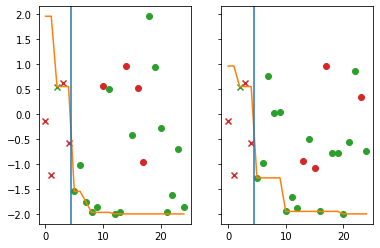

In [14]:
from util.plotting import plot_regret

mask_fail = constraint_data.observations.numpy() >= Sim.threshold
batch_mask_fail = batch_constraint_data.observations.numpy() >= Sim.threshold

fig, ax = plt.subplots(1, 2, sharey="all")
plot_regret(
    data[OBJECTIVE].observations.numpy(),
    ax[0],
    num_init=num_initial_points,
    mask_fail=mask_fail.flatten()
)
plot_regret(
    batch_data[OBJECTIVE].observations.numpy(),
    ax[1],
    num_init=num_initial_points,
    mask_fail=batch_mask_fail.flatten()
)

## LICENSE

[Apache License 2.0](https://github.com/secondmind-labs/trieste/blob/develop/LICENSE)